In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import MaxNLocator
import scienceplots
from matplotlib.lines import Line2D
import cupy as cp

# Función de bootstrapping

In [2]:
def bootstrap_confidence_intervals_df(df, param_cols, fitness_col='fitness', n_bootstrap=1000, alpha=0.05):
    """
    Calcula intervalos de confianza para:
    - la media de los parámetros
    - los parámetros del mejor individuo (fitness mínimo)
    Además imprime las medias bootstrapped.
    """

    # Convertimos a cupy
    poblacion_params = cp.asarray(df[param_cols].values)
    poblacion_fitness = cp.asarray(df[fitness_col].values)

    N, d = poblacion_params.shape
    mean_params_samples = cp.zeros((n_bootstrap, d))
    best_params_samples = cp.zeros((n_bootstrap, d))

    rng = cp.random.default_rng()

    for i in range(n_bootstrap):
        idx = rng.integers(0, N, size=N)
        sample_params = poblacion_params[idx]
        sample_fitness = poblacion_fitness[idx]

        # media de parámetros
        mean_params_samples[i] = sample_params.mean(axis=0)

        # mejores parámetros
        best_idx = cp.argmin(sample_fitness)
        best_params_samples[i] = sample_params[best_idx]

    low_q = 100 * (alpha/2)
    high_q = 100 * (1 - alpha/2)

    mean_params_CI = cp.percentile(mean_params_samples, [low_q, high_q], axis=0)
    best_params_CI = cp.percentile(best_params_samples, [low_q, high_q], axis=0)

    # >>> NUEVO: medias bootstrapped
    mean_params_boot_mean = mean_params_samples.mean(axis=0).get()
    best_params_boot_mean = best_params_samples.mean(axis=0).get()

    mean_df = pd.DataFrame({
        "param": param_cols,
        "low": mean_params_CI[0].get(),
        "high": mean_params_CI[1].get(),
        "boot_mean": mean_params_boot_mean
    })

    best_df = pd.DataFrame({
        "param": param_cols,
        "low": best_params_CI[0].get(),
        "high": best_params_CI[1].get(),
        "boot_mean": best_params_boot_mean
    })

    return {"mean_params_CI": mean_df, "best_params_CI": best_df}

# Cargado de Datos

In [5]:
exps = ['exp1-v2', 'exp2-v2', 'exp3-v2']
dfs = {}  # diccionario donde guardamos los DataFrames por experimento

for exp in exps:
    lista_dfs = []
    for generacion in range(45):
        ruta_archivo = f'resultados/{exp}/resultados_generacion_{generacion}.csv'
        if os.path.exists(ruta_archivo):
            datos = pd.read_csv(ruta_archivo)
            datos['generacion'] = generacion
            lista_dfs.append(datos)
        else:
            print(f'Archivo no encontrado: {ruta_archivo}')
            break
    
    # unir todos los de este experimento en un DataFrame
    dfs[exp] = pd.concat(lista_dfs, ignore_index=True)

# ahora accedés así:
df_exp1 = dfs['exp1-v2']
df_exp2 = dfs['exp2-v2']
df_exp3 = dfs['exp3-v2']

def limpiar_valor(x):
    if pd.isna(x):
        return x  # deja los NaN como están
    x = str(x).strip()
    if x.startswith("[") and x.endswith("]"):
        x = x[1:-1]  # quita corchetes
    try:
        return float(x)
    except ValueError:
        return pd.NA  # si no se puede convertir

for col in ["beta", "gamma"]:
    df_exp2[col] = df_exp2[col].apply(limpiar_valor).astype(float)

Archivo no encontrado: resultados/exp1-v2/resultados_generacion_32.csv
Archivo no encontrado: resultados/exp2-v2/resultados_generacion_35.csv
Archivo no encontrado: resultados/exp3-v2/resultados_generacion_40.csv


In [9]:
df_exp2

,D,A,B,x,y,beta,gamma,fitness,generacion
0,50.522945,0.000288,8.354874,371.0,605.0,0.165617,0.149055,0.827773,0
1,46.345009,0.000398,3.036181,446.0,570.0,1.488367,0.346883,0.598740,0
2,79.326210,0.000559,21.046959,512.0,518.0,0.844974,0.404021,1.191440,0
3,67.360138,0.000389,13.406980,317.0,618.0,1.493361,0.656792,0.504717,0
4,61.411880,0.000290,2.813837,443.0,627.0,1.364586,0.359913,0.283795,0
...,...,...,...,...,...,...,...,...,...
199995,39.410507,0.000092,21.360878,403.0,614.0,1.465871,0.569987,0.267171,19
199996,32.346268,0.000243,21.517298,412.0,652.0,1.114711,0.525571,0.211315,19
199997,46.236332,0.000303,17.845800,392.0,568.0,1.482263,0.900000,0.329498,19
199998,4.894711,0.000231,16.551472,355.0,612.0,1.003166,0.564597,0.325155,19


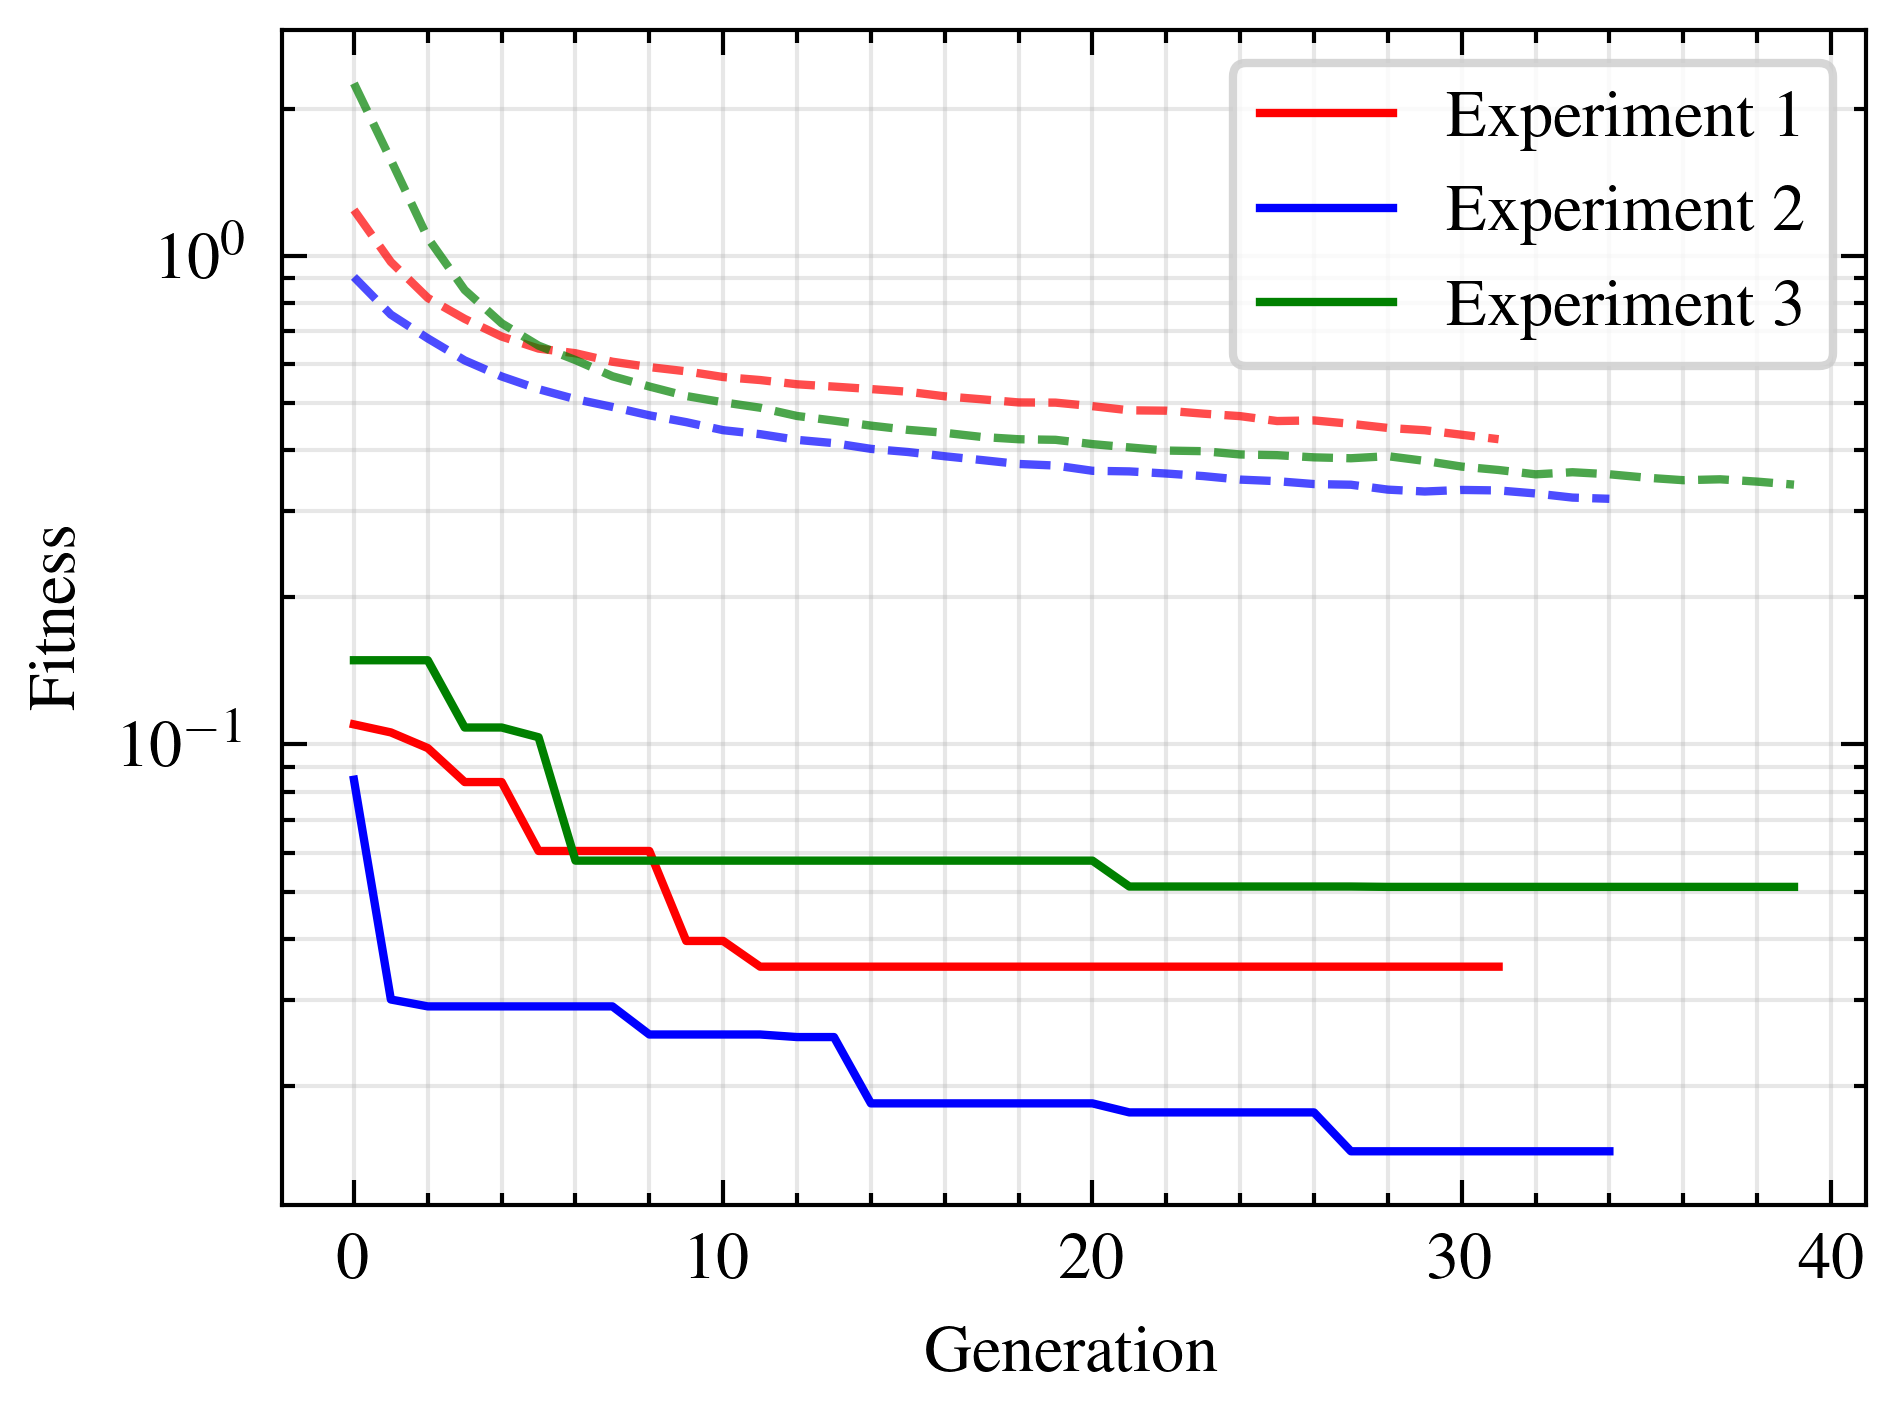

In [6]:
# Visualizaciones de los resultados del algoritmo genético

# Evolución del fitness a lo largo de las generaciones

# Experimento 1
mejor_fitness_exp1 = df_exp1.groupby('generacion')['fitness'].min()
fitness_promedio_exp1 = df_exp1.groupby('generacion')['fitness'].mean()

# Experimento 2
mejor_fitness_exp2 = df_exp2.groupby('generacion')['fitness'].min()
fitness_promedio_exp2 = df_exp2.groupby('generacion')['fitness'].mean()

# Experimento 3
mejor_fitness_exp3 = df_exp3.groupby('generacion')['fitness'].min()
fitness_promedio_exp3 = df_exp3.groupby('generacion')['fitness'].mean()

import matplotlib.ticker as ticker

with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    plt.yscale('log')
    # plt.xscale('log')
    
    # Exp1
    ax.plot(mejor_fitness_exp1.index, mejor_fitness_exp1.values, '-', color='red')
    ax.plot(fitness_promedio_exp1.index, fitness_promedio_exp1.values, '--', color='red', alpha=0.7)

    # Exp2
    ax.plot(mejor_fitness_exp2.index, mejor_fitness_exp2.values, '-', color='blue')
    ax.plot(fitness_promedio_exp2.index, fitness_promedio_exp2.values, '--', color='blue', alpha=0.7)

    # Exp3
    ax.plot(mejor_fitness_exp3.index, mejor_fitness_exp3.values, '-', color='green')
    ax.plot(fitness_promedio_exp3.index, fitness_promedio_exp3.values, '--', color='green', alpha=0.7)

    # handles personalizados para la leyenda
    legend_elements = [
        Line2D([0], [0], color='red', lw=1, label='Experiment 1'),
        Line2D([0], [0], color='blue', lw=1, label='Experiment 2'),
        Line2D([0], [0], color='green', lw=1, label='Experiment 3'),
    ]
    ax.legend(handles=legend_elements, frameon=True, loc='best')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')

    # más ticks en x (cada 5 generaciones, por ejemplo)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    # ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

    # más ticks en y (en escala logarítmica)
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=range(1, 10)))
    
    ax.grid(True, which='both', alpha=0.3)  # activa grilla en ticks menores también
    plt.tight_layout()
    plt.savefig('fitness_evolution.pdf', dpi=600, bbox_inches='tight')
    plt.show()


## Experimento 1

En este experimento ajustamos los parámetros: $D$, $A$, $B$ y las coordenadas del punto de ignición $(x,y)$.

### Mejores 10 individuos

In [17]:
# Ordenar por fitness (menor es mejor)
df_sorted = df_exp1.sort_values("fitness", ascending=True)

# Eliminar duplicados según las columnas que definen un individuo
df_unique = df_sorted.drop_duplicates(
    subset=[
        "D", "A", "B",
        "x", "y"
    ],
    keep="first"
)

# Quedarse con los 10 mejores
top10 = df_unique.head(10)

top10

# Mostrar
print("\n🏆 TOP 10 INDIVIDUOS ENCONTRADOS:")
for i, row in top10.iterrows():
    print(f"\n#{i+1}")
    print(f"   Generación: {row['generacion']}")
    print(f"   D = {row['D']}")
    print(f"   A = {row['A']}")
    print(f"   B = {row['B']}")
    print(f"   Punto de ignición: ({row['x']}, {row['y']})")
    print(f"   Fitness = {row['fitness']}")


🏆 TOP 10 INDIVIDUOS ENCONTRADOS:

#190212
   Generación: 19.0
   D = 10.743194580078123
   A = 8.881563553586602e-05
   B = 14.546717643737791
   Punto de ignición: (402.0, 600.0)
   Fitness = 0.0351001595461797

#149377
   Generación: 14.0
   D = 11.093676567077637
   A = 7.075971370795742e-05
   B = 10.40615463256836
   Punto de ignición: (400.0, 595.0)
   Fitness = 0.0379365360751639

#232902
   Generación: 23.0
   D = 11.44011688232422
   A = 0.0001361794857075
   B = 21.023822784423828
   Punto de ignición: (400.0, 606.0)
   Fitness = 0.0394433611061868

#116384
   Generación: 11.0
   D = 8.979315757751465
   A = 8.881563553586602e-05
   B = 14.546717643737791
   Punto de ignición: (402.0, 600.0)
   Fitness = 0.0396206346392483

#160811
   Generación: 16.0
   D = 11.902423858642578
   A = 0.0001432169956387
   B = 23.12657928466797
   Punto de ignición: (401.0, 606.0)
   Fitness = 0.0408615493706789

#124017
   Generación: 12.0
   D = 10.04333209991455
   A = 9.176622552331536e-0

### Análisis de los mejores 100 individuos de todas las generaciones

In [ ]:
top100_con_repeticion = df_sorted.head(100)
top100_sin_repeticion = df_unique.head(50)

print("Media de la última generación (con repetición):")
print(f"Media de D: {top100_con_repeticion["D"].mean()} +- {top100_con_repeticion["D"].std(ddof=1)}")
print(f"Media de A: {top100_con_repeticion["A"].mean()} +- {top100_con_repeticion["A"].std(ddof=1)}")
print(f"Media de B: {top100_con_repeticion["B"].mean()} +- {top100_con_repeticion["B"].std(ddof=1)}")
print(f"Media de x: {top100_con_repeticion["x"].mean()} +- {top100_con_repeticion["x"].std(ddof=1)}")
print(f"Media de y: {top100_con_repeticion["y"].mean()} +- {top100_con_repeticion["y"].std(ddof=1)}")
print(f"Fitness medio: {top100_con_repeticion['fitness'].mean()} +- {top100_con_repeticion["fitness"].std(ddof=1)}")


print("\nMedia de la última generación (sin repetición):")
print(f"Media de D: {top100_sin_repeticion["D"].mean()} +- {top100_sin_repeticion["D"].std(ddof=1)}")
print(f"Media de A: {top100_sin_repeticion["A"].mean()} +- {top100_sin_repeticion["A"].std(ddof=1)}")
print(f"Media de B: {top100_sin_repeticion["B"].mean()} +- {top100_sin_repeticion["B"].std(ddof=1)}")
print(f"Media de x: {top100_sin_repeticion["x"].mean()} +- {top100_sin_repeticion["x"].std(ddof=1)}")
print(f"Media de y: {top100_sin_repeticion["y"].mean()} +- {top100_sin_repeticion["y"].std(ddof=1)}")
print(f"Fitness medio: {top100_sin_repeticion['fitness'].mean()} +- {top100_sin_repeticion["fitness"].std(ddof=1)}")


                D         A          B      x      y   fitness  generacion
463736  10.324657  0.000093  15.851768  400.0  599.0  0.012355          46
502215  10.324657  0.000093  15.851768  400.0  599.0  0.012355          50
248968  10.324657  0.000093  15.851768  400.0  599.0  0.012355          24
422753  10.324657  0.000093  15.851768  400.0  599.0  0.012355          42
345426  10.324657  0.000093  15.851768  400.0  599.0  0.012355          34
...           ...       ...        ...    ...    ...       ...         ...
768848  15.379519  0.000072  15.001499  407.0  598.0  0.021447          76
725436  15.277098  0.000066  14.963229  407.0  596.0  0.021494          72
779699  15.186873  0.000069  15.163962  407.0  597.0  0.021494          77
799111  14.237996  0.000065  15.322006  406.0  595.0  0.021634          79
638532  13.471908  0.000084  14.588005  406.0  599.0  0.021634          63

[100 rows x 7 columns]
Media de la última generación (con repetición):
Media de D: 11.2163841247558

### Bootstrapping para darle un intervalo de confianza al mejor individuo

In [33]:
import cupy as cp
import pandas as pd

ultima_generacion = df_exp1['generacion'].max()
df_ultima_exp1 = df_exp1[df_exp1['generacion'] == ultima_generacion].copy()

# Uso
res = bootstrap_confidence_intervals_df(df_ultima_exp1, param_cols=["D", "A", "B", "x", "y"])

print("IC 95% de parámetros medios:\n", res["mean_params_CI"])
print("\nIC 95% de mejores parámetros:\n", res["best_params_CI"])

IC 95% de parámetros medios:
   param             low            high       boot_mean
0     D   14.8285799459   15.1334371799   14.9766056490
1     A    0.0002129196    0.0002158643    0.0002143468
2     B   47.9882726425   48.9215713431   48.4693086175
3     x  401.3189475000  402.0617025000  401.6876689000
4     y  605.4084800000  606.2313150000  605.8282422000

IC 95% de mejores parámetros:
   param             low            high       boot_mean
0     D    9.5467481613   14.6517248154   11.7950509834
1     A    0.0000888156    0.0001909570    0.0001203424
2     B   14.5467176437   32.2256355286   18.2230654917
3     x  393.0000000000  402.0000000000  400.0330000000
4     y  600.0000000000  609.0000000000  602.8450000000


### Análisis de la última generación

In [ ]:
# Detectar automáticamente la última generación
ultima_generacion = df_exp1['generacion'].max()
gen_ultima = df_exp1[df_exp1['generacion'] == ultima_generacion].copy()

gen_ultima_sorted = gen_ultima.sort_values("fitness", ascending=True)
gen_ultima = gen_ultima_sorted.head(100)

print("Media de la última generación (con repetición):")
print(f"Media de D: {gen_ultima["D"].mean()} +- {gen_ultima["D"].std(ddof=1)}")
print(f"Media de A: {gen_ultima["A"].mean()} +- {gen_ultima["A"].std(ddof=1)}")
print(f"Media de B: {gen_ultima["B"].mean()} +- {gen_ultima["B"].std(ddof=1)}")
print(f"Media de x: {gen_ultima["x"].mean()} +- {gen_ultima["x"].std(ddof=1)}")
print(f"Media de y: {gen_ultima["y"].mean()} +- {gen_ultima["y"].std(ddof=1)}")
print(f"Fitness medio: {gen_ultima['fitness'].mean()} +- {gen_ultima["fitness"].std(ddof=1)}")


df_unique = gen_ultima_sorted.drop_duplicates(
    subset=[
        "D", "A", "B",
        "x", "y"
    ],
    keep="first"
)
gen_ultima_top_k = df_unique.head(100)
print("\nMedia de la última generación (sin repetición):")
print(f"Media de D: {gen_ultima_top_k["D"].mean()} +- {gen_ultima_top_k["D"].std(ddof=1)}")
print(f"Media de A: {gen_ultima_top_k["A"].mean()} +- {gen_ultima_top_k["A"].std(ddof=1)}")
print(f"Media de B: {gen_ultima_top_k["B"].mean()} +- {gen_ultima_top_k["B"].std(ddof=1)}")
print(f"Media de x: {gen_ultima_top_k["x"].mean()} +- {gen_ultima_top_k["x"].std(ddof=1)}")
print(f"Media de y: {gen_ultima_top_k["y"].mean()} +- {gen_ultima_top_k["y"].std(ddof=1)}")
print(f"Fitness medio: {gen_ultima_top_k['fitness'].mean()} +- {gen_ultima_top_k["fitness"].std(ddof=1)}")

Media de la última generación (con repetición):
Media de D: 15.59739972114563 +- 0.8439428118780467
Media de A: 6.936116540600778e-05 +- 5.411479106510748e-06
Media de B: 14.927545022964477 +- 0.28932783944861634
Media de x: 407.25 +- 1.0671873729054748
Media de y: 597.22 +- 0.9906634854551486
Fitness medio: 0.024995803804550486 +- 0.001972034160156515

Media de la última generación (sin repetición):
Media de D: 15.601240320205688 +- 0.8475524011298541
Media de A: 6.936629204574275e-05 +- 5.411118617552814e-06
Media de B: 14.929048976898194 +- 0.28907102566205845
Media de x: 407.25 +- 1.0671873729054748
Media de y: 597.23 +- 0.9934634854737726
Fitness medio: 0.025005128683327063 +- 0.001978435106286378


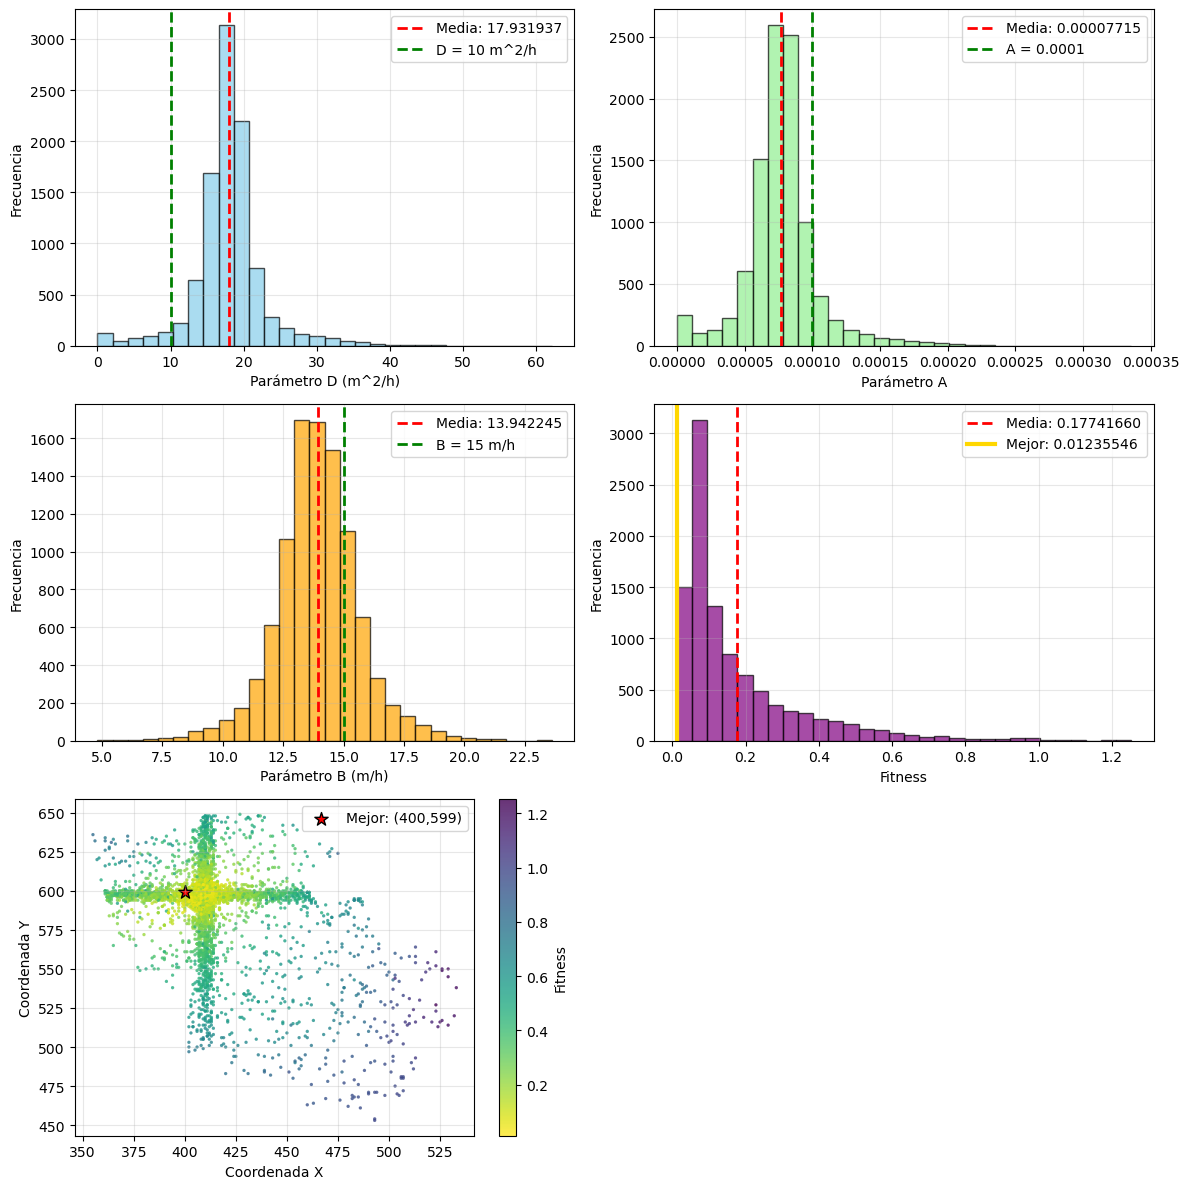

In [ ]:
# Visualizaciones específicas para la ÚLTIMA GENERACIÓN

# Crear figura con 3 filas y 2 columnas (6 ejes en total, usamos 5)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()  # pasar a lista simple para indexar fácilmente

n_bins = 30

# 1. Distribución del parámetro D
axes[0].hist(gen_ultima['D'], bins=n_bins, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].axvline(gen_ultima['D'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["D"].mean():.6f}')
axes[0].axvline(10, color='green', linestyle='--', linewidth=2,
                  label=f'D = {10} m^2/h')
axes[0].set_xlabel('Parámetro D (m^2/h)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Distribución del parámetro A
axes[1].hist(gen_ultima['A'], bins=n_bins, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1].axvline(gen_ultima['A'].mean(), color='red', linestyle='--', linewidth=2,
                         label=f'Media: {gen_ultima["A"].mean():.8f}')
axes[1].axvline(1e-4, color='green', linestyle='--', linewidth=2,
                         label=f'A = {1e-4}')
axes[1].set_xlabel('Parámetro A')
axes[1].set_ylabel('Frecuencia')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Distribución del parámetro B
axes[2].hist(gen_ultima['B'], bins=n_bins, color='orange', alpha=0.7, edgecolor='black')
axes[2].axvline(gen_ultima['B'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["B"].mean():.6f}')
axes[2].axvline(15, color='green', linestyle='--', linewidth=2,
                 label=f'B = {15} m/h')
axes[2].set_xlabel('Parámetro B (m/h)')
axes[2].set_ylabel('Frecuencia')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# 4. Distribución del fitness
axes[3].hist(gen_ultima['fitness'], bins=n_bins, color='purple', alpha=0.7, edgecolor='black')
axes[3].axvline(gen_ultima['fitness'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["fitness"].mean():.8f}')
axes[3].axvline(gen_ultima['fitness'].min(), color='gold', linestyle='-', linewidth=3,
                 label=f'Mejor: {gen_ultima["fitness"].min():.8f}')
axes[3].set_xlabel('Fitness')
axes[3].set_ylabel('Frecuencia')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# 5. Puntos de ignición coloreados por fitness
scatter = axes[4].scatter(gen_ultima['x'], gen_ultima['y'], 
                          c=gen_ultima['fitness'], s=5, cmap='viridis_r', 
                          alpha=0.8, linewidths=0.1)
mejor_gen_ultima = gen_ultima.loc[gen_ultima['fitness'].idxmin()]
axes[4].scatter(mejor_gen_ultima['x'], mejor_gen_ultima['y'], 
                 c='red', s=100, marker='*', edgecolors='black', linewidth=1,
                 label=f'Mejor: ({mejor_gen_ultima["x"]:.0f},{mejor_gen_ultima["y"]:.0f})')
axes[4].set_xlabel('Coordenada X')
axes[4].set_ylabel('Coordenada Y')
axes[4].legend()
axes[4].grid(True, alpha=0.3)
fig.colorbar(scatter, ax=axes[4], label='Fitness')

# Eliminar el subplot vacío (el sexto)
fig.delaxes(axes[5])

# Ajustar diseño
plt.tight_layout()
plt.savefig(f'resultados_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')
plt.show()

## Experimento 2

Ajustamos los parámetros $D$, $A$, $B$, $\beta$, $\gamma$ y las coordenadas del punto de ignición $(x,y)$. El terreno es homogéneo así que hay un solo tipo de combustible

### Mejores 10 individuos

In [34]:
# Ordenar por fitness (menor es mejor)
df_sorted = df_exp2.sort_values("fitness", ascending=True)

# Eliminar duplicados según las columnas que definen un individuo
# (acá pongo todas las que listaste, podés ajustar si alguna no hace falta)
df_unique = df_sorted.drop_duplicates(
    subset=[
        "D", "A", "B",
        "x", "y",
        "beta", "gamma"
    ],
    keep="first"
)

# Quedarse con los 10 mejores
top10 = df_unique.head(10)

# Mostrar
print("\n🏆 TOP 10 INDIVIDUOS ENCONTRADOS:")
for i, row in top10.iterrows():
    print(f"\n#{i+1}")
    print(f"   Generación: {row['generacion']}")
    print(f"   D = {row['D']}")
    print(f"   A = {row['A']}")
    print(f"   B = {row['B']}")
    print(f"   x = {row['x']}")
    print(f"   y = {row['y']}")
    print(f"   beta = {row['beta']}")
    print(f"   gamma = {row['gamma']}")
    print(f"   Fitness = {row['fitness']}")


🏆 TOP 10 INDIVIDUOS ENCONTRADOS:

#149289
   Generación: 14.0
   D = 42.25390625
   A = 0.0001256347459275
   B = 25.492151260375977
   x = 402.0
   y = 603.0
   beta = 0.8609594702720642
   gamma = 0.3390779793262481
   Fitness = 0.0184345955910592

#193343
   Generación: 19.0
   D = 23.34027099609375
   A = 0.0001358620647806
   B = 20.71243476867676
   x = 399.0
   y = 603.0
   beta = 1.2756540775299072
   gamma = 0.5805964469909668
   Fitness = 0.0200092172977955

#185947
   Generación: 18.0
   D = 23.34027099609375
   A = 0.0001358620647806
   B = 20.71243476867676
   x = 399.0
   y = 603.0
   beta = 1.082886815071106
   gamma = 0.4042614102363586
   Fitness = 0.0211613795222367

#146426
   Generación: 14.0
   D = 43.83023834228516
   A = 0.0001127693540183
   B = 22.983932495117188
   x = 405.0
   y = 605.0
   beta = 0.7333759665489197
   gamma = 0.2056970596313476
   Fitness = 0.0241954067132652

#182176
   Generación: 18.0
   D = 44.8068962097168
   A = 0.0001402052293997
   B

### Análisis Bootstrap

In [35]:
ultima_generacion = df_exp2['generacion'].max()
print("Última generación:", ultima_generacion)
df_ultima_exp2 = df_exp2[df_exp2['generacion'] == ultima_generacion].copy()

# Uso
res = bootstrap_confidence_intervals_df(df_ultima_exp2, param_cols=["D", "A", "B", "x", "y", "beta", "gamma"])

print("IC 95% de parámetros medios:\n", res["mean_params_CI"].round(7))
print("\nIC 95% de mejores parámetros:\n", res["best_params_CI"].round(7))

Última generación: 20
IC 95% de parámetros medios:
    param          low         high    boot_mean
0      D   32.4391895   32.8943683   32.6750850
1      A    0.0001418    0.0001448    0.0001432
2      B   26.2839151   27.0619583   26.6790426
3      x  402.6045575  403.6147275  403.1018404
4      y  603.3304175  604.3696650  603.8388907
5   beta    1.0953885    1.1052269    1.1005055
6  gamma    0.4589805    0.4671625    0.4632330

IC 95% de mejores parámetros:
    param          low         high    boot_mean
0      D   29.1577015   42.2539062   41.0177979
1      A    0.0000145    0.0001256    0.0001130
2      B   14.8420115   35.7886581   27.3864064
3      x  401.0000000  424.0000000  405.7980000
4      y  593.0000000  603.0000000  602.0050000
5   beta    0.8609595    1.0777236    0.9165159
6  gamma    0.2609550    0.5569003    0.3828226


### Análisis de la última Generación

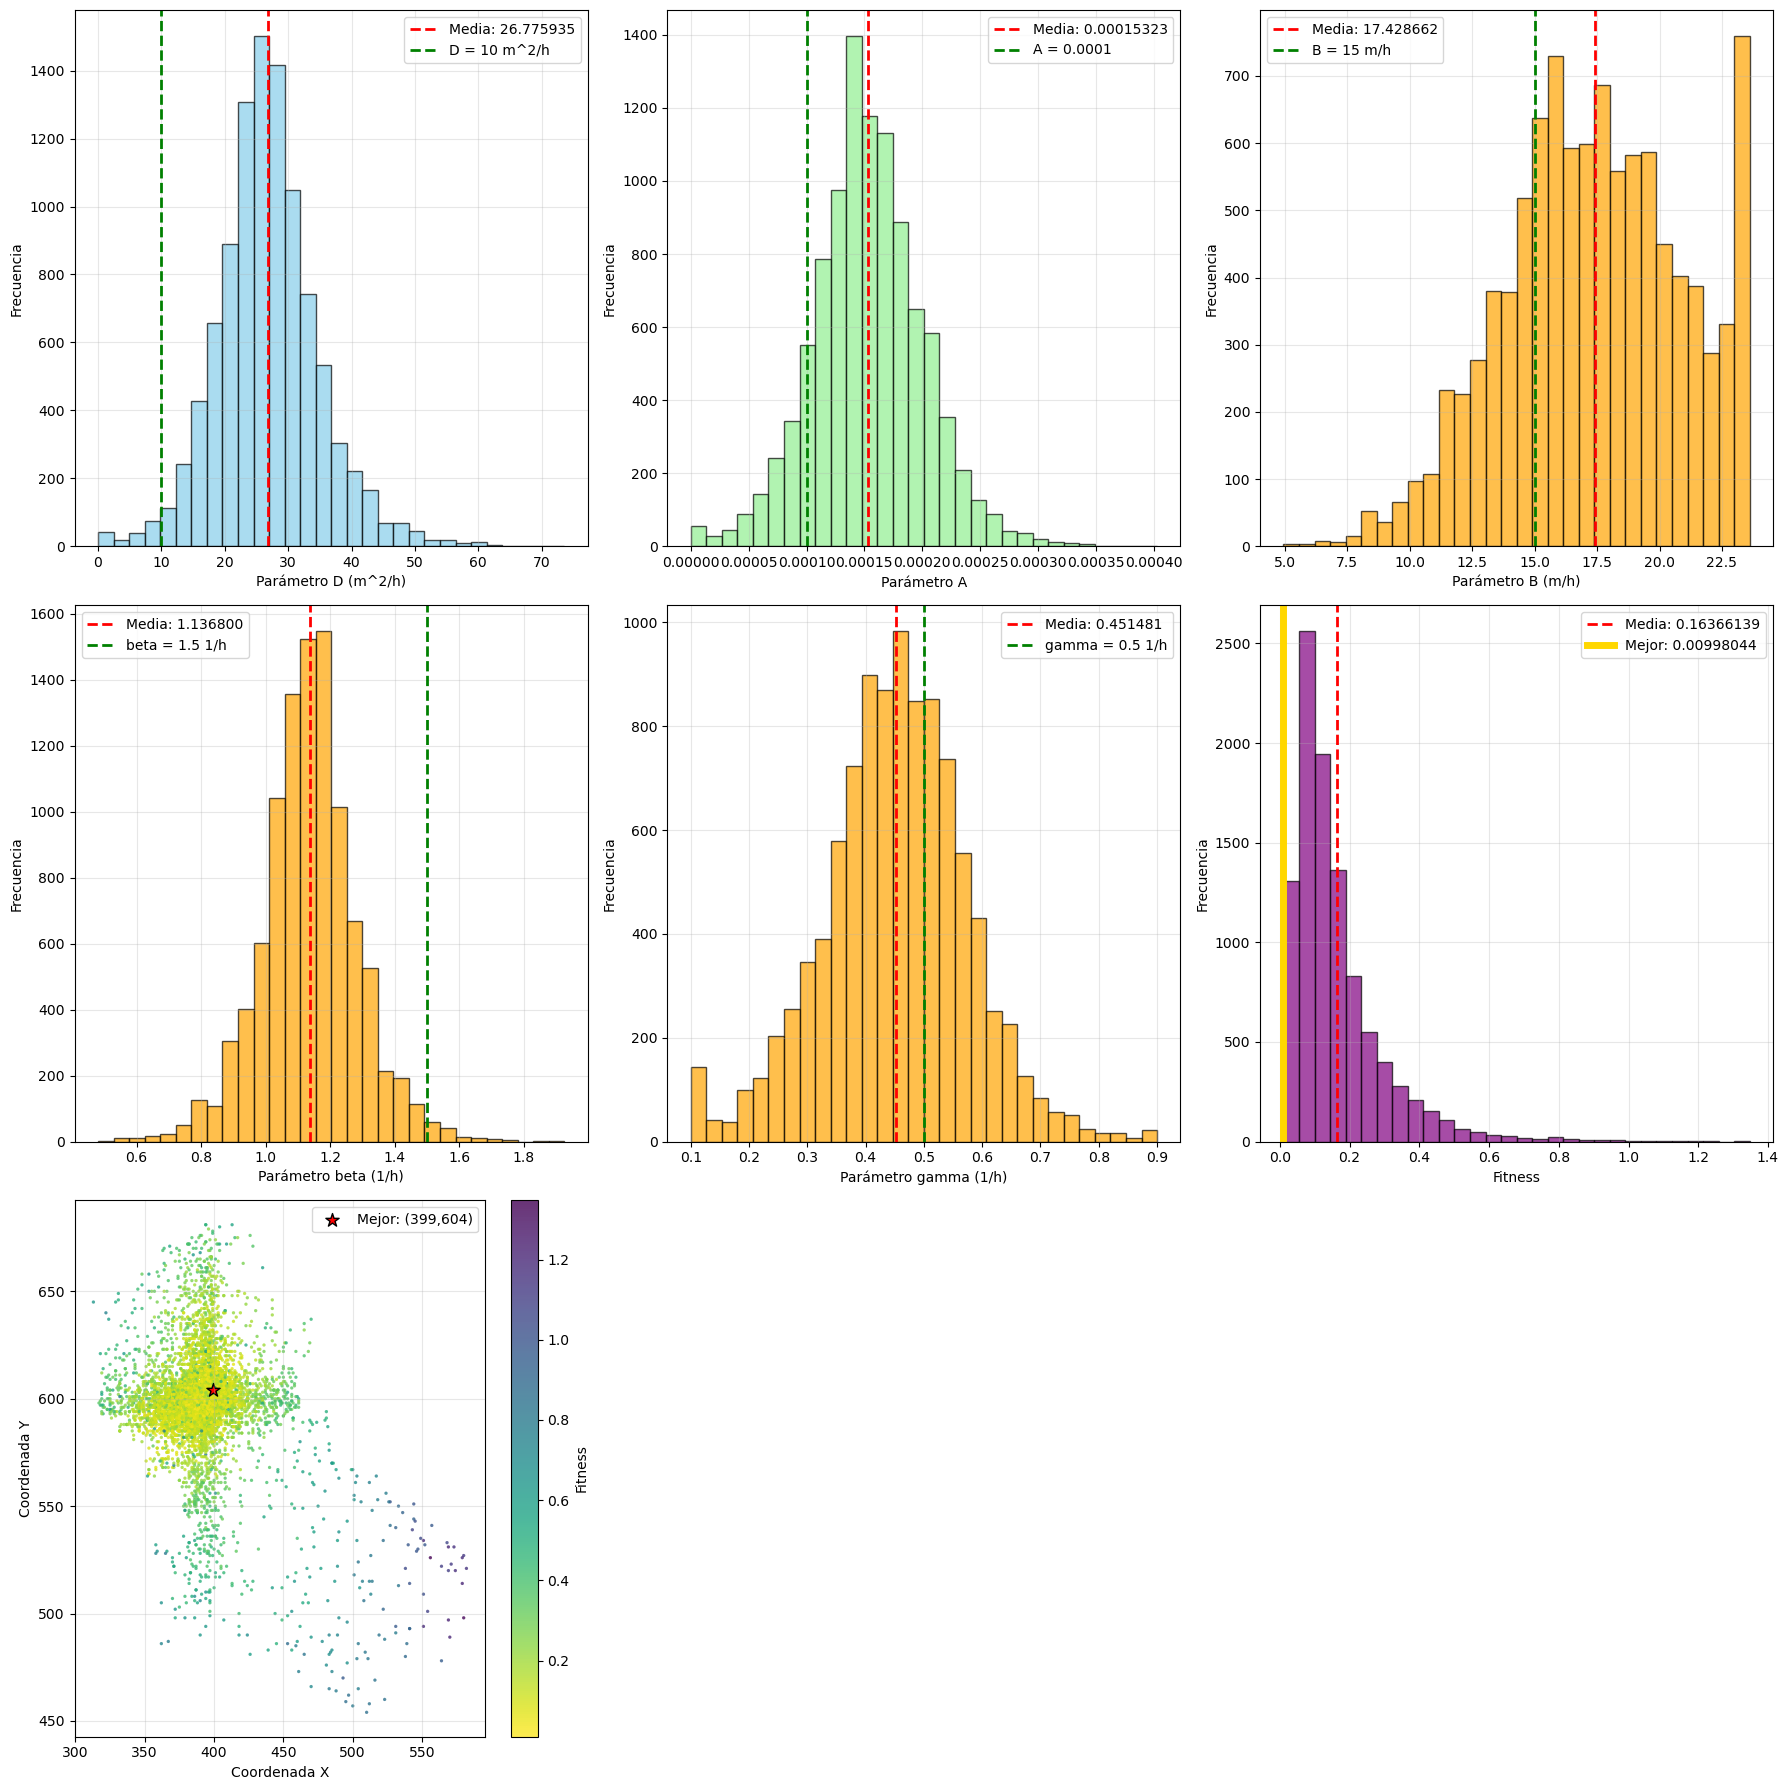

In [50]:
# Visualizaciones específicas para la ÚLTIMA GENERACIÓN

# Detectar automáticamente la última generación
ultima_generacion = df_exp2['generacion'].max()
gen_ultima = df_exp2[df_exp2['generacion'] == ultima_generacion].copy()

# Crear figura con 3 filas y 3 columnas (6 ejes en total, usamos 5)
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()  # pasar a lista simple para indexar fácilmente

n_bins = 30

# 1. Distribución del parámetro D
axes[0].hist(gen_ultima['D'], bins=n_bins, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].axvline(gen_ultima['D'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["D"].mean():.6f}')
axes[0].axvline(10, color='green', linestyle='--', linewidth=2,
                  label=f'D = {10} m^2/h')
axes[0].set_xlabel('Parámetro D (m^2/h)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Distribución del parámetro A
axes[1].hist(gen_ultima['A'], bins=n_bins, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1].axvline(gen_ultima['A'].mean(), color='red', linestyle='--', linewidth=2,
                         label=f'Media: {gen_ultima["A"].mean():.8f}')
axes[1].axvline(1e-4, color='green', linestyle='--', linewidth=2,
                         label=f'A = {1e-4}')
axes[1].set_xlabel('Parámetro A')
axes[1].set_ylabel('Frecuencia')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Distribución del parámetro B
axes[2].hist(gen_ultima['B'], bins=n_bins, color='orange', alpha=0.7, edgecolor='black')
axes[2].axvline(gen_ultima['B'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["B"].mean():.6f}')
axes[2].axvline(15, color='green', linestyle='--', linewidth=2,
                 label=f'B = {15} m/h')
axes[2].set_xlabel('Parámetro B (m/h)')
axes[2].set_ylabel('Frecuencia')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

axes[3].hist(gen_ultima['beta'], bins=n_bins, color='orange', alpha=0.7, edgecolor='black')
axes[3].axvline(gen_ultima['beta'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["beta"].mean():.6f}')
axes[3].axvline(1.5, color='green', linestyle='--', linewidth=2,
                 label=f'beta = {1.5} 1/h')
axes[3].set_xlabel('Parámetro beta (1/h)')
axes[3].set_ylabel('Frecuencia')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

axes[4].hist(gen_ultima['gamma'], bins=n_bins, color='orange', alpha=0.7, edgecolor='black')
axes[4].axvline(gen_ultima['gamma'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["gamma"].mean():.6f}')
axes[4].axvline(0.5, color='green', linestyle='--', linewidth=2,
                 label=f'gamma = {0.5} 1/h')
axes[4].set_xlabel('Parámetro gamma (1/h)')
axes[4].set_ylabel('Frecuencia')
axes[4].legend()
axes[4].grid(True, alpha=0.3)

# 4. Distribución del fitness
axes[5].hist(gen_ultima['fitness'], bins=n_bins, color='purple', alpha=0.7, edgecolor='black')
axes[5].axvline(gen_ultima['fitness'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["fitness"].mean():.8f}')
axes[5].axvline(gen_ultima['fitness'].min(), color='gold', linestyle='-', linewidth=5,
                 label=f'Mejor: {gen_ultima["fitness"].min():.8f}')
axes[5].set_xlabel('Fitness')
axes[5].set_ylabel('Frecuencia')
axes[5].legend()
axes[5].grid(True, alpha=0.3)

# 5. Puntos de ignición coloreados por fitness
scatter = axes[6].scatter(gen_ultima['x'], gen_ultima['y'], 
                          c=gen_ultima['fitness'], s=5, cmap='viridis_r', 
                          alpha=0.8, linewidths=0.1)
mejor_gen_ultima = gen_ultima.loc[gen_ultima['fitness'].idxmin()]
axes[6].scatter(mejor_gen_ultima['x'], mejor_gen_ultima['y'], 
                 c='red', s=100, marker='*', edgecolors='black', linewidth=1,
                 label=f'Mejor: ({mejor_gen_ultima["x"]:.0f},{mejor_gen_ultima["y"]:.0f})')
axes[6].set_xlabel('Coordenada X')
axes[6].set_ylabel('Coordenada Y')
axes[6].legend()
axes[6].grid(True, alpha=0.3)
fig.colorbar(scatter, ax=axes[6], label='Fitness')

# Eliminar el subplot vacío (el sexto)
fig.delaxes(axes[7])
fig.delaxes(axes[8])

# Ajustar diseño
plt.tight_layout()
plt.savefig(f'resultados_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')
plt.show()

In [65]:
plt.style.use(['science', 'ieee'])  # estilo global para todos los gráficos

n_bins = 30
ultima_generacion = df_exp2['generacion'].max()
gen_ultima = df_exp2[df_exp2['generacion'] == ultima_generacion].copy()

# 1. Distribución del parámetro D
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots(figsize=(3.5, 3.0))  # tamaño típico de paper (en pulgadas)
    ax.hist(gen_ultima['D'], bins=n_bins, color='skyblue', alpha=0.7, edgecolor='black')
    ax.axvline(gen_ultima['D'].mean(), color='red', linestyle='--', linewidth=1.2,
                  label=f'Mean: {gen_ultima["D"].mean():.6f}')
    ax.axvline(10, color='green', linestyle='--', linewidth=1.2,
                  label=f'D = {10} m$^2$/h')
    ax.set_xlabel(r'Parameter $D$ (m$^2$/h)')
    ax.set_ylabel('Frequence')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'distribucion_D_generacion_{ultima_generacion}.pdf', dpi=600, bbox_inches='tight')
    plt.close()

## Experimento 3

En este experimento generamos un multiincendio en 3 focos distintos y ajustamos los parámetros $D$, $A$, $B$, $\beta_i$, $\gamma_i$ para $i \in \{1, 2, 3, 4, 5\}$

### Mejores 10 individuos

In [18]:
# Ordenar por fitness (menor es mejor)
df_sorted = df_exp3.sort_values("fitness", ascending=True)

# Eliminar duplicados según las columnas que definen un individuo
# (acá pongo todas las que listaste, podés ajustar si alguna no hace falta)
df_unique = df_sorted.drop_duplicates(
    subset=[
        "D", "A", "B",
        "beta_1", "beta_2", "beta_3", "beta_4", "beta_5",
        "gamma_1", "gamma_2", "gamma_3", "gamma_4", "gamma_5",
    ],
    keep="first"
)

# Quedarse con los 10 mejores
top10 = df_unique.head(10)

# Mostrar
print("\n🏆 TOP 10 INDIVIDUOS ENCONTRADOS:")
for i, row in top10.iterrows():
    print(f"\n#{i+1}")
    print(f"   Generación: {row['generacion']}")
    print(f"   D = {row['D']}")
    print(f"   A = {row['A']}")
    print(f"   B = {row['B']}")
    print(f"   beta_1 = {row['beta_1']}")
    print(f"   beta_2 = {row['beta_2']}")
    print(f"   beta_3 = {row['beta_3']}")
    print(f"   beta_4 = {row['beta_4']}")
    print(f"   beta_5 = {row['beta_5']}")
    print(f"   gamma_1 = {row['gamma_1']}")
    print(f"   gamma_2 = {row['gamma_2']}")
    print(f"   gamma_3 = {row['gamma_3']}")
    print(f"   gamma_4 = {row['gamma_4']}")
    print(f"   gamma_5 = {row['gamma_5']}")
    print(f"   Fitness = {row['fitness']}")

# mejor_individuo = top10
# print(mejor_individuo)


🏆 TOP 10 INDIVIDUOS ENCONTRADOS:

#283391
   Generación: 28.0
   D = 21.645666122436523
   A = 0.0001106506606447
   B = 12.223675727844238
   beta_1 = 0.5058301687240601
   beta_2 = 0.5111005902290344
   beta_3 = 0.6460356116294861
   beta_4 = 1.5245314836502075
   beta_5 = 0.4872851967811584
   gamma_1 = 0.2341605573892593
   gamma_2 = 0.2432596385478973
   gamma_3 = 0.1065316349267959
   gamma_4 = 0.3739565908908844
   gamma_5 = 0.1000000014901161
   Fitness = 0.0511182786572168

#233262
   Generación: 23.0
   D = 9.337833404541016
   A = 8.842546958476305e-05
   B = 12.851133346557615
   beta_1 = 0.6358364224433899
   beta_2 = 0.5807396769523621
   beta_3 = 0.9422074556350708
   beta_4 = 1.951478123664856
   beta_5 = 0.4546942412853241
   gamma_1 = 0.2124993801116943
   gamma_2 = 0.2104389667510986
   gamma_3 = 0.1508242040872573
   gamma_4 = 0.234999343752861
   gamma_5 = 0.1278465390205383
   Fitness = 0.0512031574926792

#182227
   Generación: 18.0
   D = 19.247482299804688
   

### Análisis bootstrap

In [26]:
ultima_generacion = df_exp3['generacion'].max()
df_ultima_exp3 = df_exp3[df_exp3['generacion'] == ultima_generacion].copy()
pd.set_option("display.precision", 10)

# Uso
res = bootstrap_confidence_intervals_df(df_ultima_exp3, param_cols=["D", "A", "B", "beta_1", "beta_2", "beta_3", "beta_4", "beta_5", 
                                                                    "gamma_1", "gamma_2", "gamma_3", "gamma_4", "gamma_5"])

print("IC 95% de parámetros medios:\n", res["mean_params_CI"].round(7))
print("\nIC 95% de mejores parámetros:\n", res["best_params_CI"].round(7))

IC 95% de parámetros medios:
       param         low        high   boot_mean
0         D  16.6363433  17.0206640  16.8283061
1         A   0.0000976   0.0000992   0.0000984
2         B   7.6404474   8.0128651   7.8252839
3    beta_1   0.6005467   0.6111253   0.6058683
4    beta_2   0.5257410   0.5339709   0.5298585
5    beta_3   1.0354995   1.0548580   1.0451800
6    beta_4   1.4733538   1.4881819   1.4808481
7    beta_5   0.5857308   0.5998351   0.5925539
8   gamma_1   0.2469550   0.2527233   0.2497483
9   gamma_2   0.2170893   0.2216572   0.2193396
10  gamma_3   0.2657459   0.2721541   0.2687952
11  gamma_4   0.3593096   0.3662745   0.3627001
12  gamma_5   0.1763771   0.1806154   0.1784533

IC 95% de mejores parámetros:
       param         low        high   boot_mean
0         D   5.9165316  19.2474823  16.0954085
1         A   0.0000959   0.0001124   0.0001081
2         B  11.8540087  22.4759903  17.8167324
3    beta_1   0.4159540   0.9042952   0.5344930
4    beta_2   0.4208842   

### Análisis de la última generación

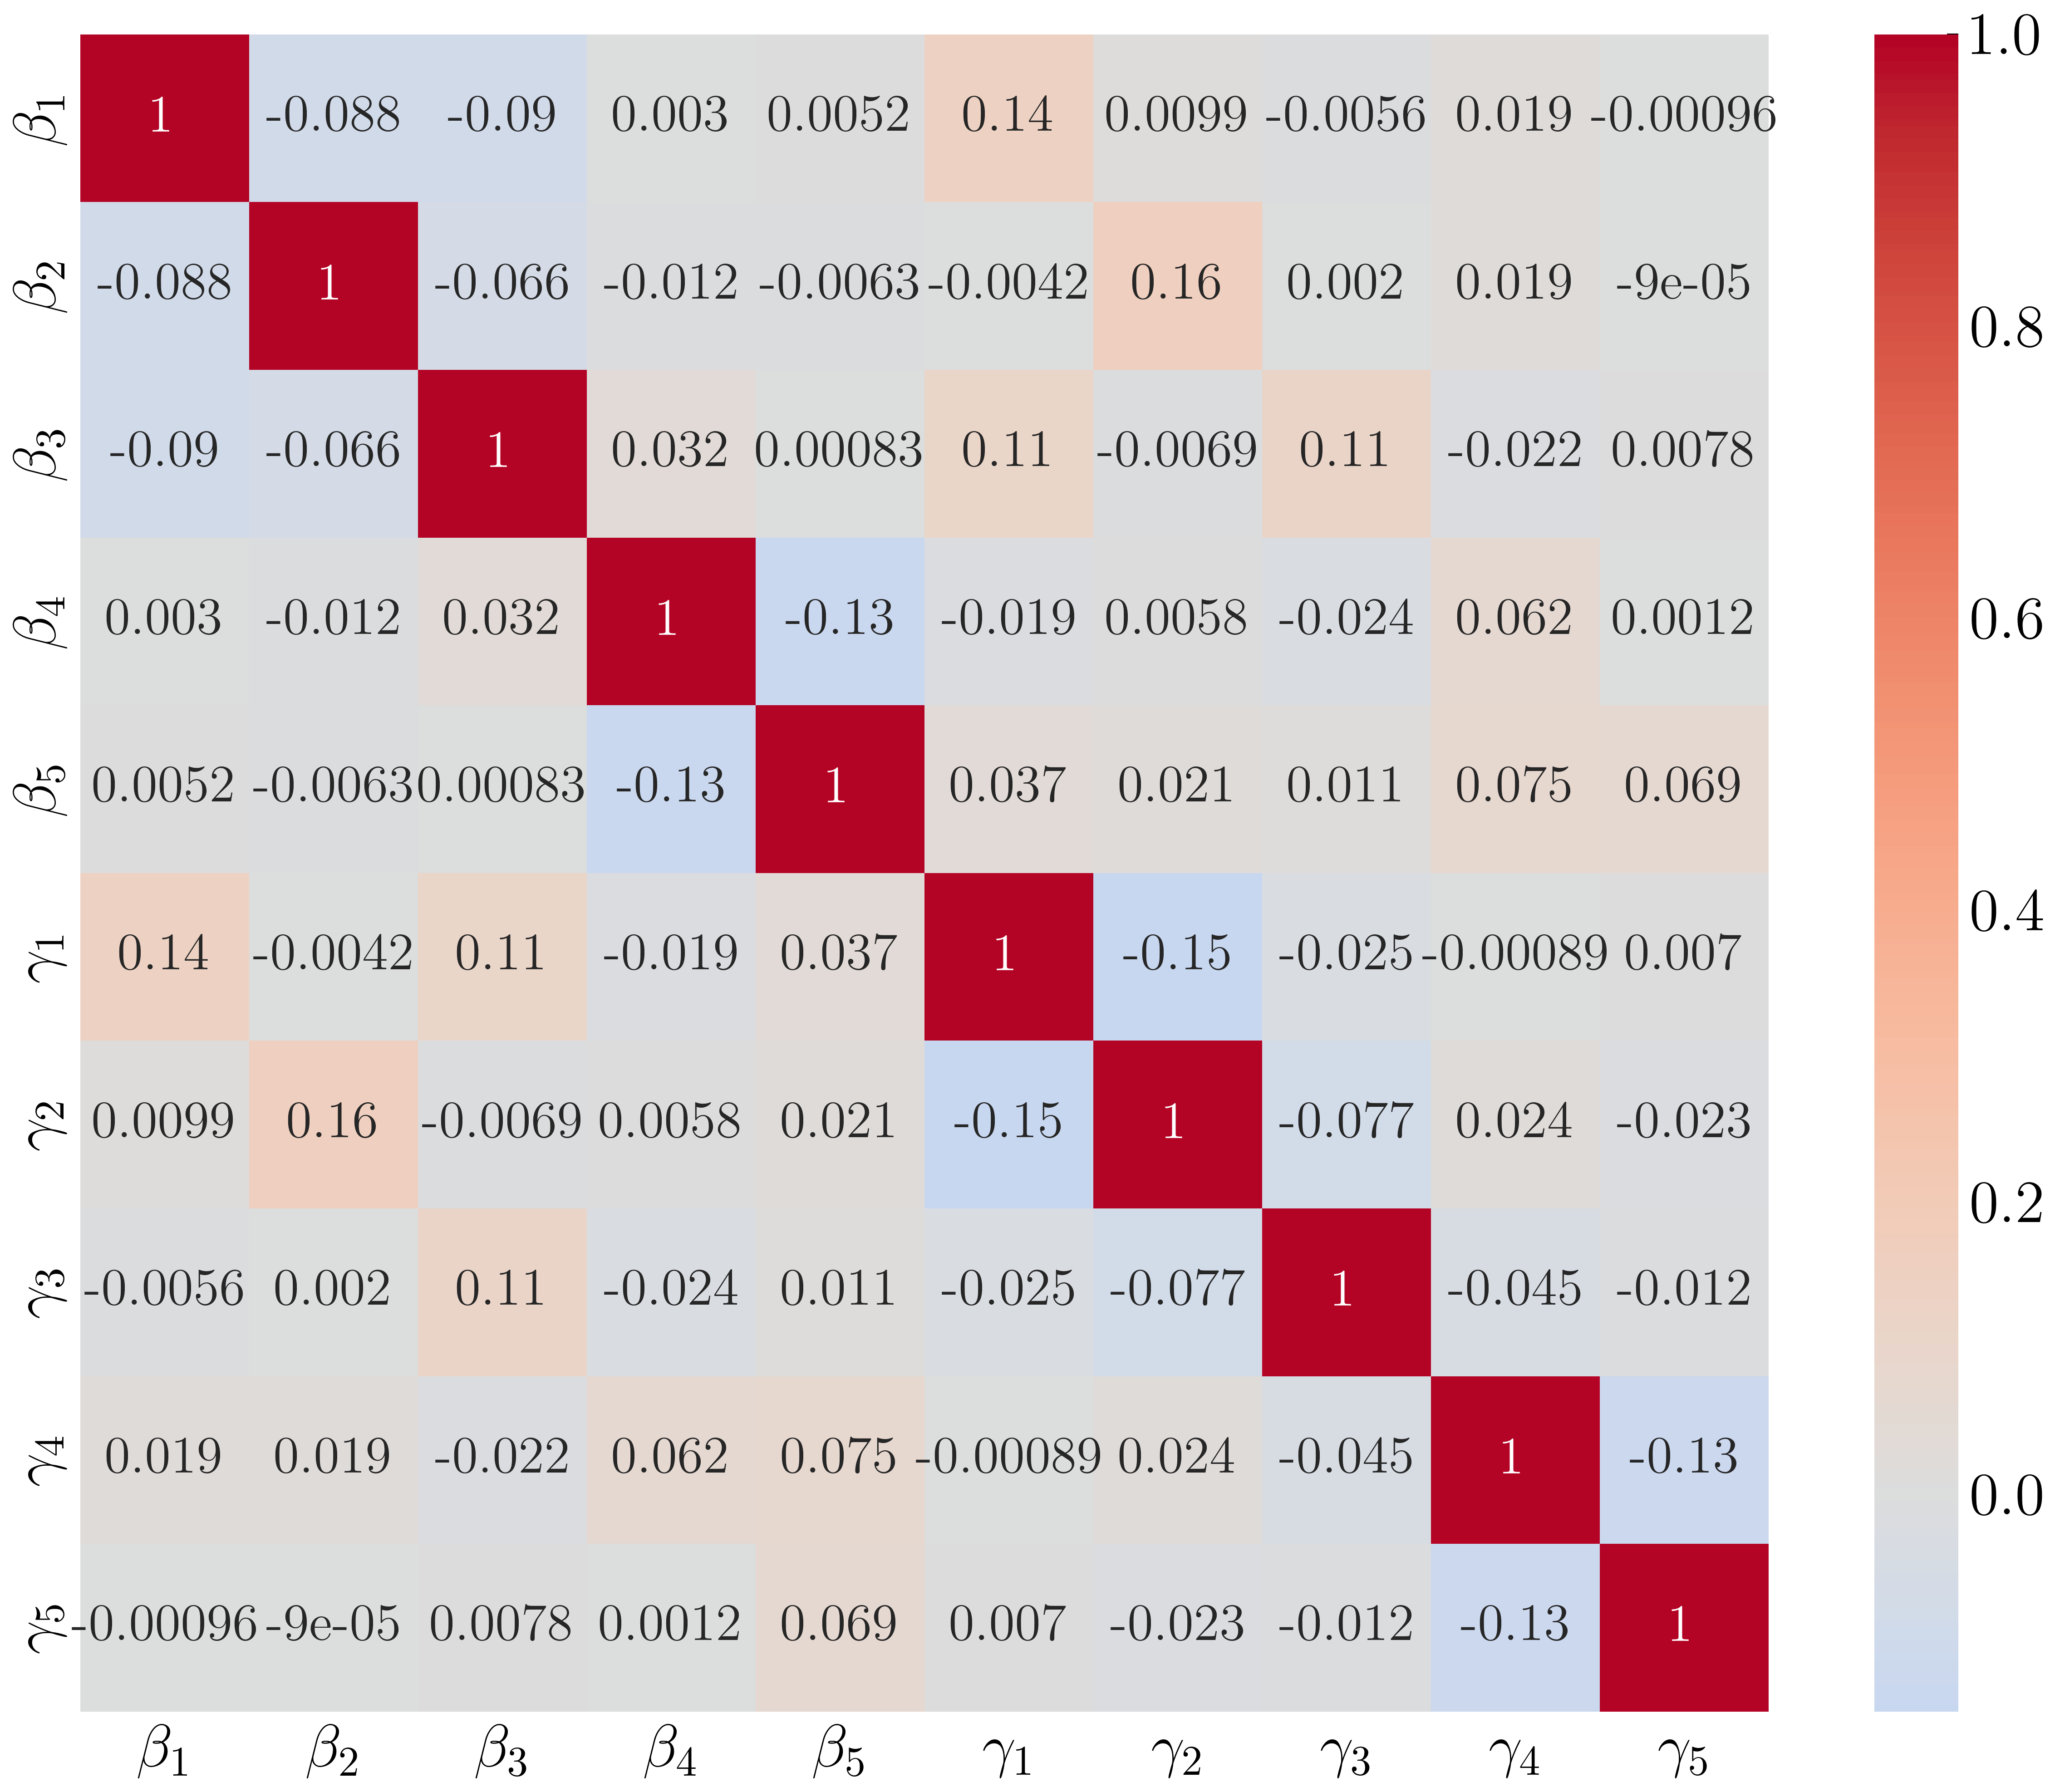

In [95]:
ultima_generacion = df_exp3['generacion'].max()
gen_ultima = df_exp3[df_exp3['generacion'] == ultima_generacion].copy()

import seaborn as sns

gen_ultima_limpia = gen_ultima.drop(columns=['fitness', 'generacion', 'D', 'A', 'B'])

betas = [col for col in gen_ultima_limpia.columns if col.startswith("beta")]
gammas = [col for col in gen_ultima_limpia.columns if col.startswith("gamma")]

xticks = [r"$\beta_{%d}$" % (i+1) for i in range(len(betas))] + [r"$\gamma_{%d}$" % (i+1) for i in range(len(gammas))]

# # --- Opción 1: Matriz de correlación completa ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    gen_ultima_limpia.corr(), 
    annot=True, 
    annot_kws={"size": 14},
    cmap="coolwarm", 
    center=0,
    xticklabels=xticks,   # etiquetas eje X
    yticklabels=xticks     # etiquetas eje Y
)
plt.show()

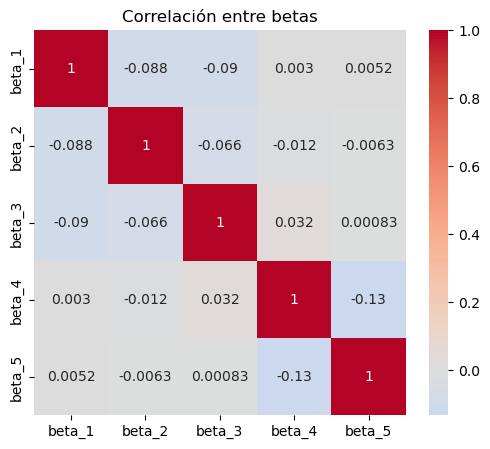

In [71]:
# --- Opción 2: Solo betas ---
betas = [col for col in gen_ultima_limpia.columns if col.startswith("beta")]
plt.figure(figsize=(6, 5))
sns.heatmap(gen_ultima_limpia[betas].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlación entre betas")
plt.show()

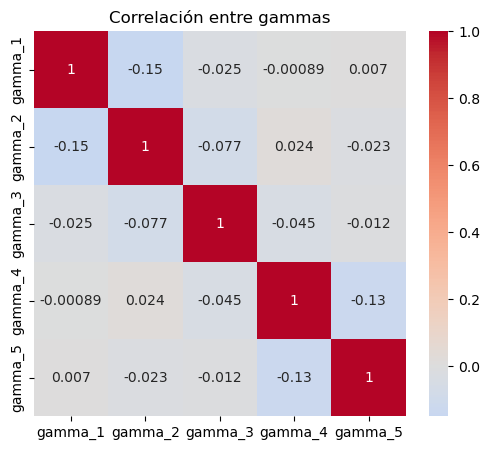

In [72]:
# --- Opción 3: Solo gammas ---
gammas = [col for col in gen_ultima_limpia.columns if col.startswith("gamma")]
plt.figure(figsize=(6, 5))
sns.heatmap(gen_ultima_limpia[gammas].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlación entre gammas")
plt.show()

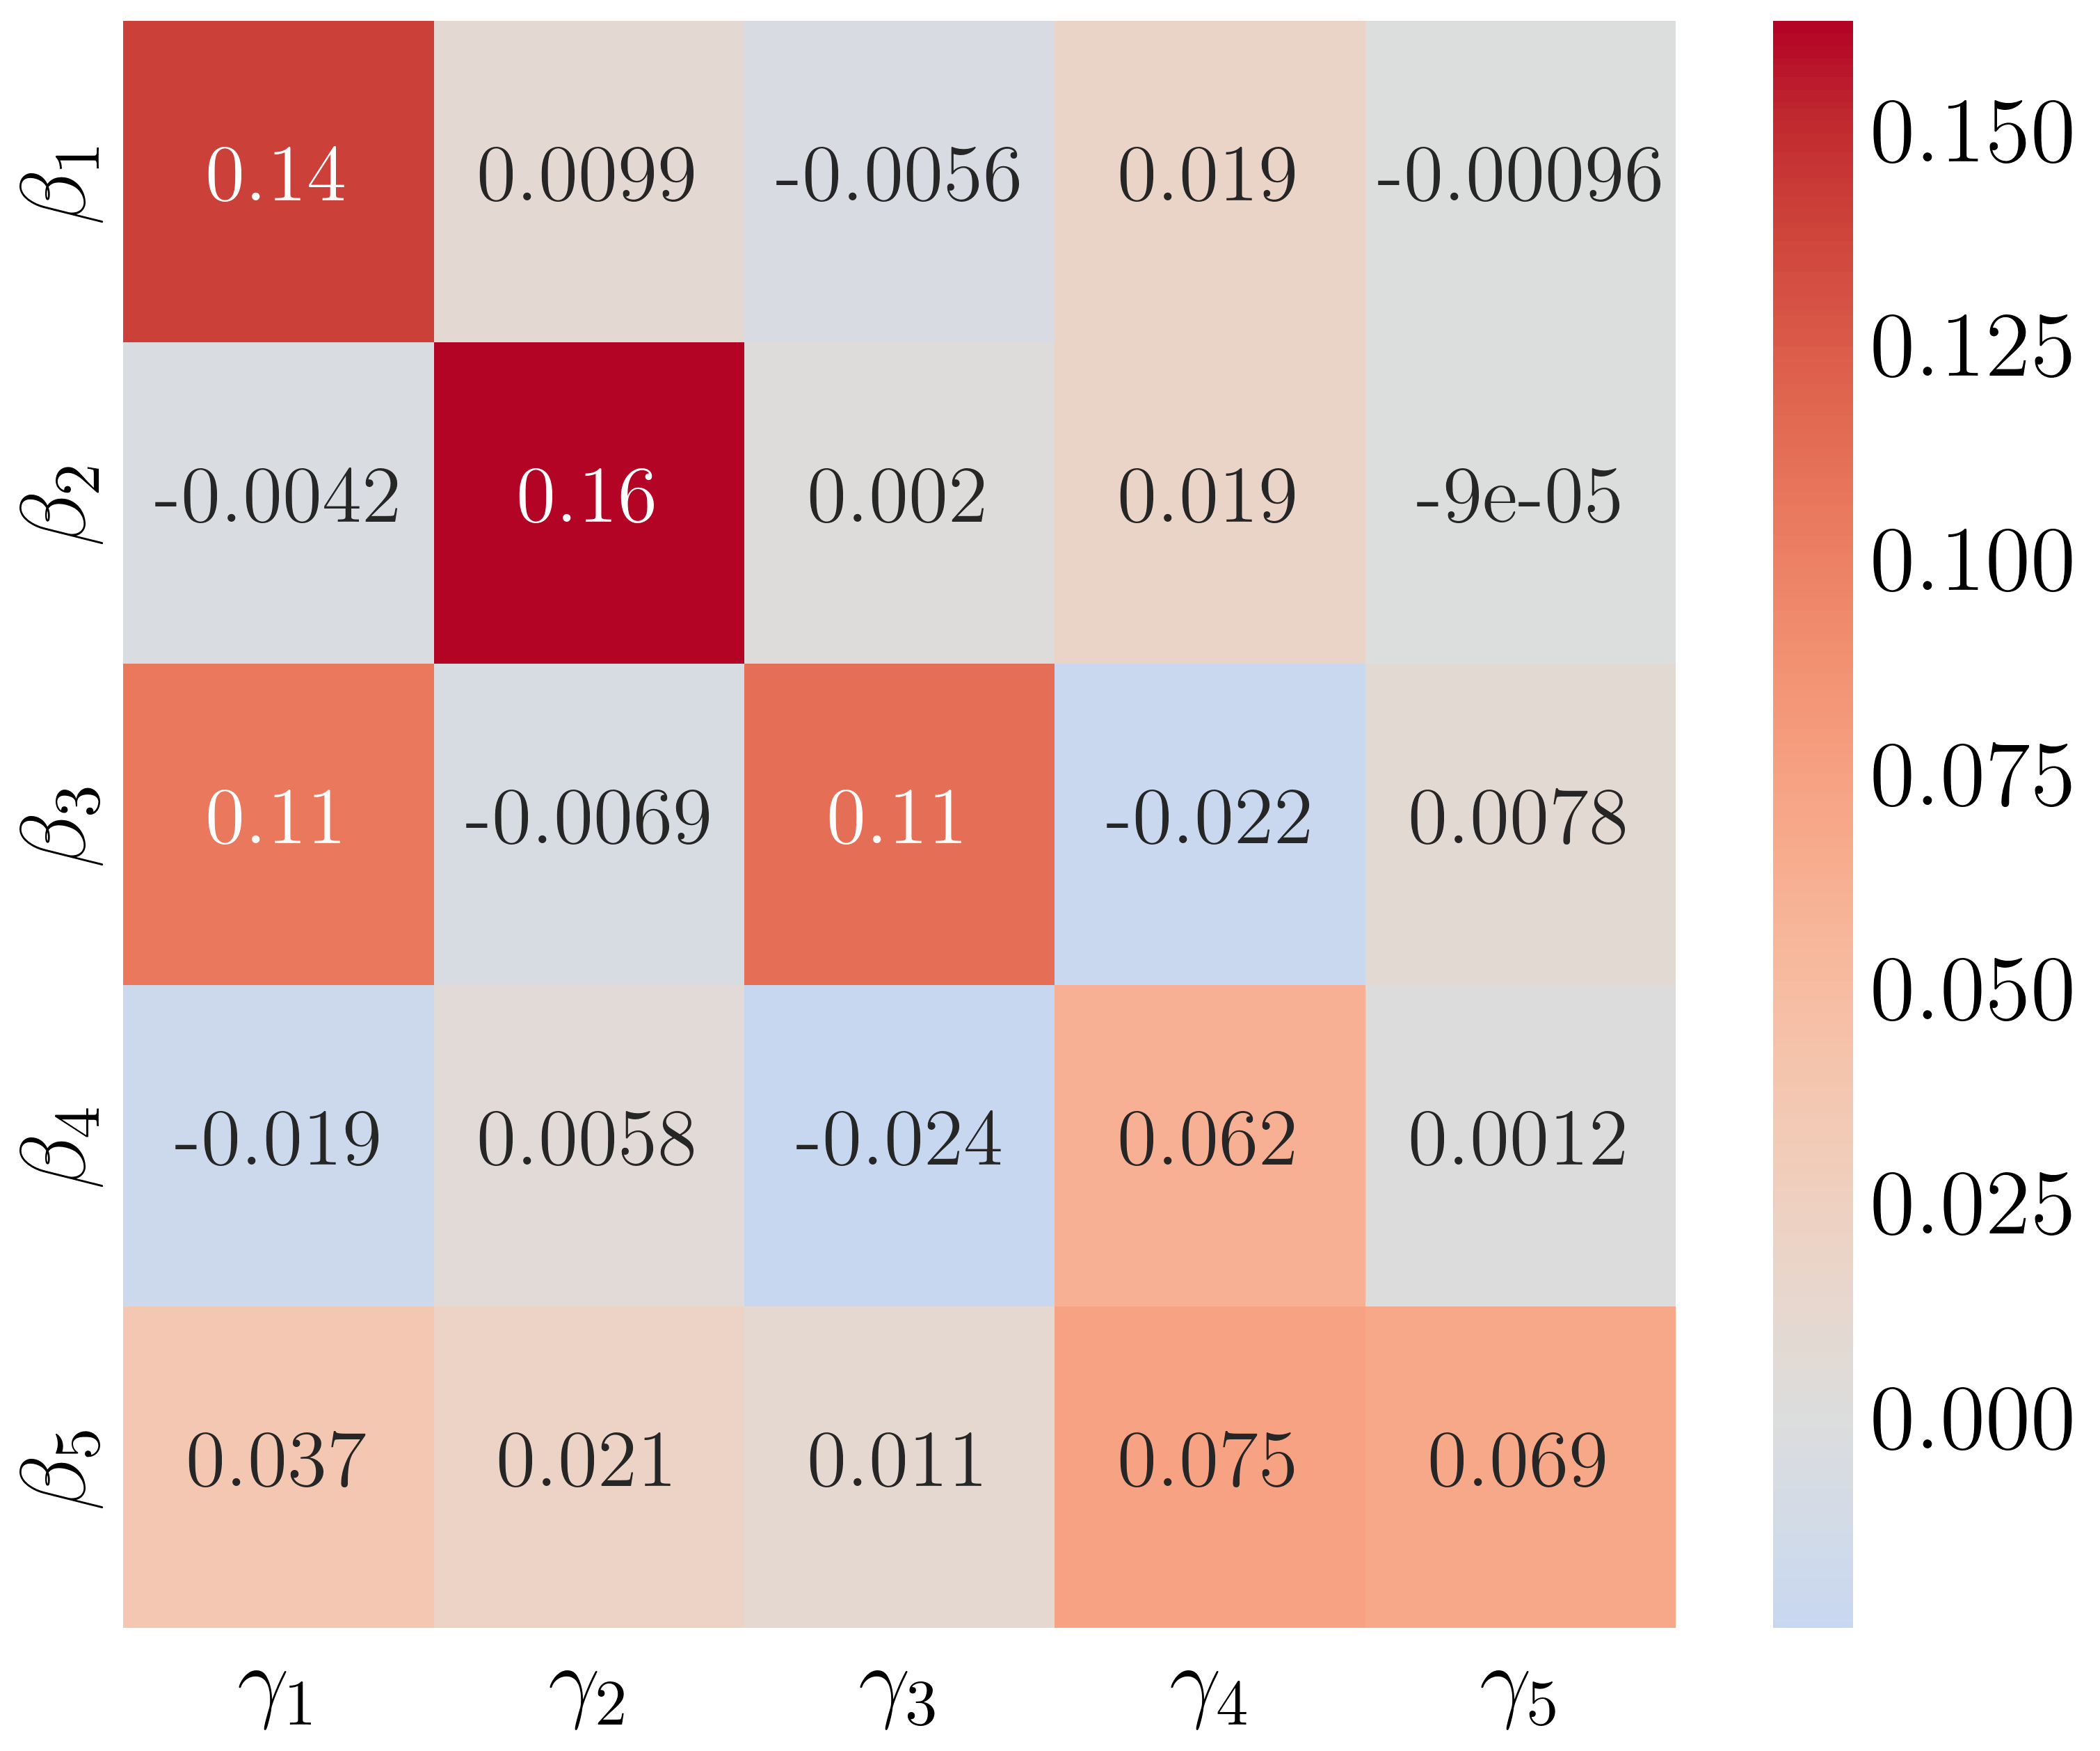

In [88]:
import scienceplots

plt.style.use(['science'])

xticks = [r"$\gamma_{%d}$" % (i+1) for i in range(len(gammas))]
yticks = [r"$\beta_{%d}$" % (i+1) for i in range(len(betas))]

# --- Opción 4: Correlación beta_i vs gamma_j ---
plt.figure(figsize=(6, 5))
corr_beta_gamma = gen_ultima_limpia[betas + gammas].corr().loc[betas, gammas]
sns.heatmap(
    corr_beta_gamma, 
    annot=True, 
    annot_kws={"size": 14},
    cmap="coolwarm", 
    center=0,
    xticklabels=xticks,   # etiquetas eje X
    yticklabels=yticks     # etiquetas eje Y
)

plt.show()

# Ajuste del Incendio Real

In [3]:
df_real = {}  # diccionario donde guardamos los DataFrames por experimento

lista_dfs = []
for generacion in range(102):
    ruta_archivo = f'resultados/Incendio Real/resultados_generacion_{generacion}.csv'
    if os.path.exists(ruta_archivo):
        datos = pd.read_csv(ruta_archivo)
        datos['generacion'] = generacion
        lista_dfs.append(datos)
    else:
        print(f'Archivo no encontrado: {ruta_archivo}')
        break
    
    # unir todos los de este experimento en un DataFrame
    df_real = pd.concat(lista_dfs, ignore_index=True)


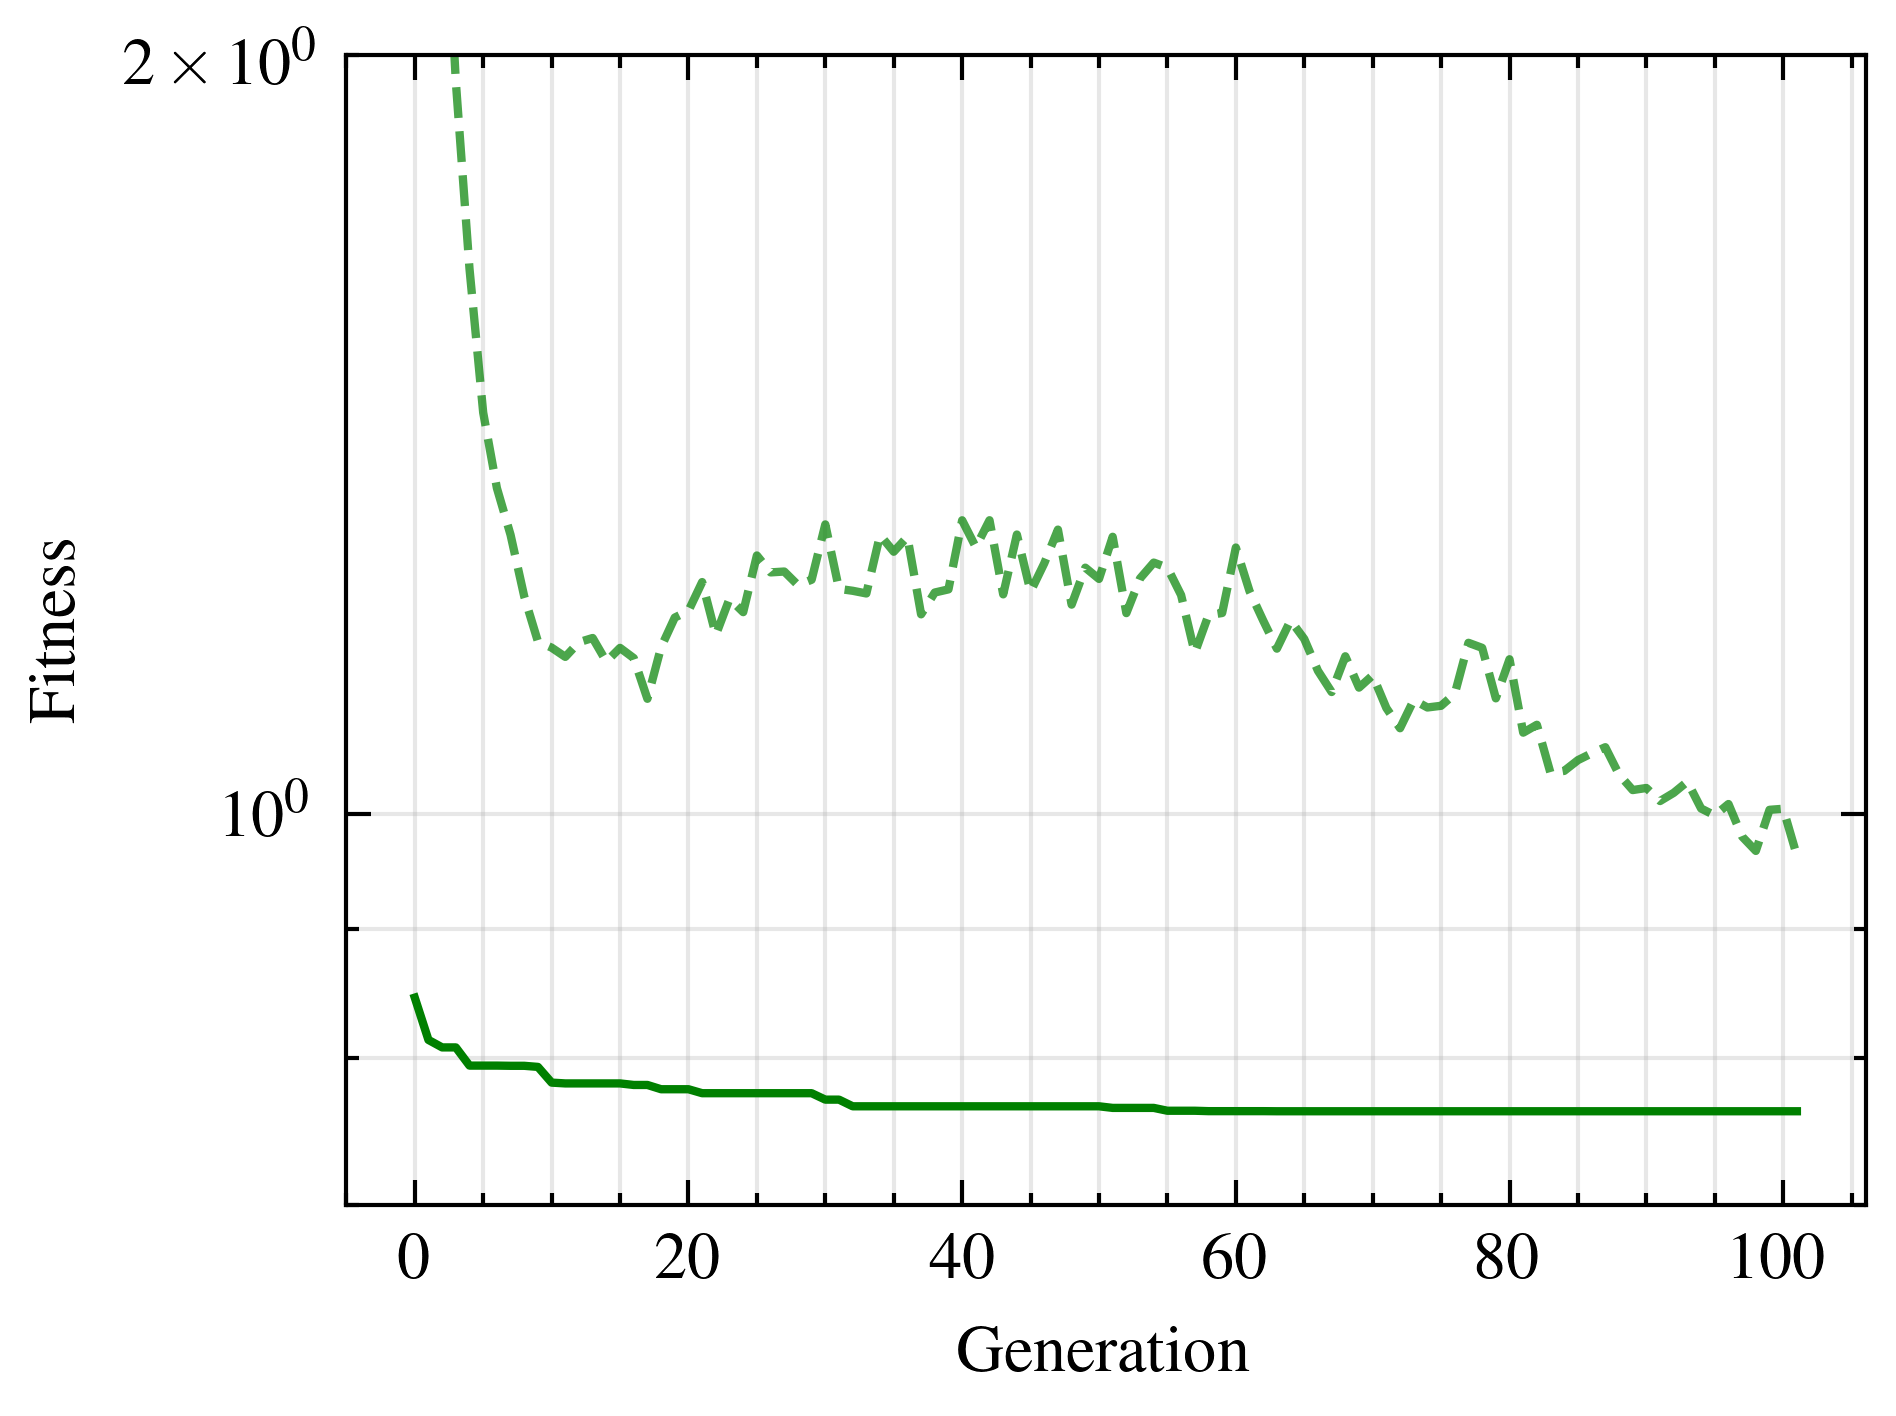

In [12]:
mejor_fitness_real = df_real.groupby('generacion')['fitness'].min()
fitness_promedio_real = df_real.groupby('generacion')['fitness'].mean()

import matplotlib.ticker as ticker

with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    plt.yscale('log')

    ax.plot(mejor_fitness_real.index, mejor_fitness_real.values, '-', color='green')
    ax.plot(fitness_promedio_real.index, fitness_promedio_real.values, '--', color='green', alpha=0.7)

    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')

    # más ticks en x (cada 5 generaciones, por ejemplo)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    # ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

    plt.ylim(0.7, 2)

    # más ticks en y (en escala logarítmica)
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=range(1, 10)))
    
    ax.grid(True, which='both', alpha=0.3)  # activa grilla en ticks menores también
    plt.tight_layout()
    # plt.savefig('fitness_evolution.pdf', dpi=600, bbox_inches='tight')
    plt.show()

In [19]:
# Ordenar por fitness (menor es mejor)
df_sorted = df_real.sort_values("fitness", ascending=True)

# Eliminar duplicados según las columnas que definen un individuo
# (acá pongo todas las que listaste, podés ajustar si alguna no hace falta)
df_unique = df_sorted.drop_duplicates(
    subset=[
        "D", "A", "B",
        "beta_1", "beta_2", "beta_3", "beta_4",
        "gamma_1", "gamma_2", "gamma_3", "gamma_4",
    ],
    keep="first"
)

# Quedarse con los 10 mejores
top10 = df_unique.head(10)

# Mostrar
print("\n🏆 TOP 10 INDIVIDUOS ENCONTRADOS:")
for i, row in top10.iterrows():
    print(f"\n#{i+1}")
    print(f"   Generación: {row['generacion']}")
    print(f"   D = {row['D']}")
    print(f"   A = {row['A']}")
    print(f"   B = {row['B']}")
    print(f"   beta_1 = {row['beta_1']}")
    print(f"   beta_2 = {row['beta_2']}")
    print(f"   beta_3 = {row['beta_3']}")
    print(f"   beta_4 = {row['beta_4']}")
    print(f"   gamma_1 = {row['gamma_1']}")
    print(f"   gamma_2 = {row['gamma_2']}")
    print(f"   gamma_3 = {row['gamma_3']}")
    print(f"   gamma_4 = {row['gamma_4']}")
    print(f"   Fitness = {row['fitness']}")

# mejor_individuo = top10
# print(mejor_individuo)


🏆 TOP 10 INDIVIDUOS ENCONTRADOS:

#189241
   Generación: 94.0
   D = 12.506118774414062
   A = 0.0
   B = 0.0
   beta_1 = 0.7971129417419434
   beta_2 = 0.1000000014901161
   beta_3 = 0.1000000014901161
   beta_4 = 2.605513095855713
   gamma_1 = 0.5369475483894348
   gamma_2 = 0.089999996125698
   gamma_3 = 0.089999996125698
   gamma_4 = 0.1000000014901161
   Fitness = 0.762315162410335

#119536
   Generación: 59.0
   D = 12.506118774414062
   A = 0.0
   B = 0.0
   beta_1 = 0.7971129417419434
   beta_2 = 0.1000000014901161
   beta_3 = 0.1000000014901161
   beta_4 = 2.605513095855713
   gamma_1 = 0.5369475483894348
   gamma_2 = 0.089999996125698
   gamma_3 = 0.089999996125698
   gamma_4 = 0.089999996125698
   Fitness = 0.7623856606566911

#119375
   Generación: 59.0
   D = 12.506118774414062
   A = 0.0
   B = 0.0
   beta_1 = 0.7971129417419434
   beta_2 = 0.1000000014901161
   beta_3 = 0.1000000014901161
   beta_4 = 2.856227159500122
   gamma_1 = 0.5369475483894348
   gamma_2 = 0.08999